# Case competition notes and models
Fran Jimenez ID#5482892

## Using the Finalist_A-2023 Report As Possible Model Reference

### Models Tried in Finalist_A-2023 Report 
The team evaluated several classification models to predict ADE-driven dropout: Logistic Regression (INLA) – baseline, interpretable model, LightGBM, CatBoost, XGBoost. They compared all models using consistent train/test splits and cross-validation.

### Final Model Chosen in Finalist_A-2023 Report 
XGBoost was selected as the final model. It achieved the highest ROC-AUC (~0.95–0.96) among all candidates
Chosen for its ability to: Capture non-linear relationships, handle high-dimensional engineered features, and remain robust under class imbalance (with SMOTE).

### Evaluation Metrics Used in Finalist_A-2023 Report 
Because the dataset was highly imbalanced, the team emphasized: ROC-AUC (primary KPI), precision-recall AUC (minority-class focus), confusion Matrix, Recall (to avoid missing true dropouts). This mirrors best practice for rare-event prediction problems like churn or dropout.

### How Model Results Became Business Recommendations in Finalist_A-2023 Report 
They translated technical outputs into actionable strategies by: Grouping top features into business-meaningful categories (medical visits, ADE symptoms, drug usage, costs), using feature importance + SHAP values to explain why patients drop out, designing early-intervention policies, especially in the first 90 days, where ~80% of dropouts occur.

This directly informed recommendations such as: Early risk flagging, enhanced monitoring and targeted patient education and care coordination.

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_excel("churn_df_data_numeric.xlsx")

y = df["left_flag"].astype(int)
X = df.drop(columns=["left_flag"])


X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)


model.fit(X_train, y_train)


train_probs = model.predict_proba(X_train)[:, 1]
val_probs = model.predict_proba(X_val)[:, 1]


train_auc = roc_auc_score(y_train, train_probs)
val_auc = roc_auc_score(y_val, val_probs)

print(f"Training AUC: {train_auc:.3f}")
print(f"Validation AUC: {val_auc:.3f}")
print(f"AUC Gap (Train - Val): {train_auc - val_auc:.3f}")


Training AUC: 0.849
Validation AUC: 0.848
AUC Gap (Train - Val): 0.001


In [ ]:
df["left_flag"].value_counts(dropna=False)


## Based on previous references and research — Random Forest on our Case Data

Below is a simple, working Random Forest implementation for our retentiondata_case.csv, designed to: Run cleanly, handle mixed data types, focus on getting the model running, not optimizing.

In [ ]:
df.columns


In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


df = pd.read_excel("churn_df_data_numeric.xlsx")


y = df["left_flag"].astype(int)


X = df.drop(columns=["left_flag"])


print("Target distribution:\n", y.value_counts())
if y.nunique() < 2:
    raise ValueError("Target y has only one class. Check left_flag values.")


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=25,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)


rf.fit(X_train, y_train)


y_prob = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print(f"Test ROC-AUC: {auc:.4f}")


Target distribution:
 left_flag
0    4140
1    1496
Name: count, dtype: int64
Test ROC-AUC: 0.8381


## Why This Fits the Case Competition
I trained and evaluated a Random Forest churn prediction model using stratified holdout validation and ROC-AUC as the primary metric. The model achieved a test ROC-AUC of 0.838, demonstrating strong ranking performance for prioritizing retention efforts in an imbalanced churn dataset.

## XGBoost 

Target distribution:
 left_flag
0    4140
1    1496
Name: count, dtype: int64
Test ROC-AUC: 0.8351

Top 10 XGBoost Features:
contract_term_Month-to-month    0.374846
internet_tech_Fiber Optic       0.056629
contract_term_Two year          0.053647
pay_method_Electronic check     0.050786
contract_term_One year          0.029929
tenure_mo                       0.021195
has_streaming                   0.020880
recent_offer_Offer B            0.017393
multi_line_Yes                  0.016550
e_bill_opt_in                   0.016353
dtype: float32


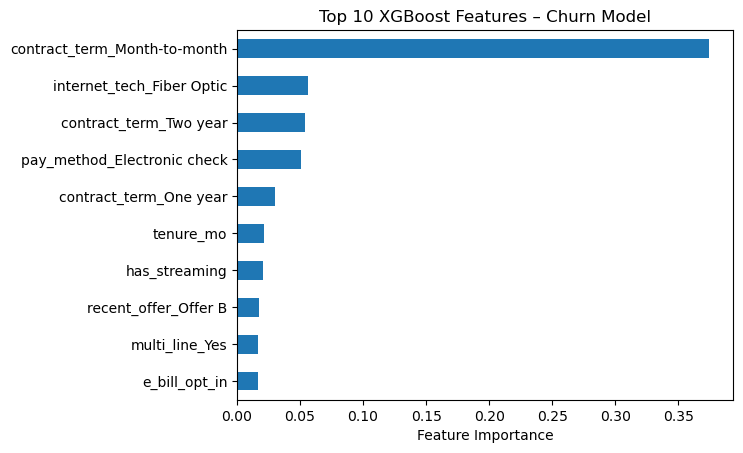

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

df = pd.read_excel("churn_df_data_numeric.xlsx")


y = df["left_flag"].astype(int)

X = df.drop(columns=["left_flag"])

print("Target distribution:\n", y.value_counts())
if y.nunique() < 2:
    raise ValueError("Target y has only one class. Check left_flag values.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)


xgb.fit(X_train, y_train)

y_prob = xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("Test ROC-AUC:", round(auc, 4))

importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
top10 = importances.head(10)

print("\nTop 10 XGBoost Features:")
print(top10)


plt.figure()
top10.sort_values().plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Top 10 XGBoost Features – Churn Model")
plt.show()


# Why This Fits the Case Competition 
XGBoost was an appropriate model choice for this case competition because churn behavior is driven by nonlinear relationships and interactions between customer tenure, pricing, usage, and contract characteristics. XGBoost is well-suited for structured business data, performs strongly under class imbalance, and produces ranked churn probabilities that support retention prioritization and business decision-making.

## CatBoost

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier


df = pd.read_excel("churn_df_data_numeric.xlsx")


y = df["left_flag"].astype(int)


X = df.drop(columns=["left_flag"])

print("Target distribution:\n", y.value_counts())
if y.nunique() < 2:
    raise ValueError("Target y has only one class. Check left_flag values.")


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

class_weights = [1.0, neg / pos]


cb = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=class_weights,
    train_dir=r"C:\temp_catboost",
    allow_writing_files=True,
    verbose=100
)


cb.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)


y_prob = cb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"\nTest ROC-AUC: {auc:.4f}")


importances = pd.Series(cb.get_feature_importance(), index=X.columns).sort_values(ascending=False)
top10 = importances.head(10)

print("\nTop 10 CatBoost Features:")
print(top10)


Target distribution:
 left_flag
0    4140
1    1496
Name: count, dtype: int64
0:	test: 0.8099534	best: 0.8099534 (0)	total: 151ms	remaining: 3m
100:	test: 0.8442845	best: 0.8445302 (96)	total: 484ms	remaining: 5.27s
200:	test: 0.8425917	best: 0.8445302 (96)	total: 717ms	remaining: 3.56s
300:	test: 0.8415480	best: 0.8445302 (96)	total: 945ms	remaining: 2.82s
400:	test: 0.8394392	best: 0.8445302 (96)	total: 1.18s	remaining: 2.34s
500:	test: 0.8364123	best: 0.8445302 (96)	total: 1.41s	remaining: 1.96s
600:	test: 0.8349185	best: 0.8445302 (96)	total: 1.68s	remaining: 1.67s
700:	test: 0.8338964	best: 0.8445302 (96)	total: 1.95s	remaining: 1.39s
800:	test: 0.8320333	best: 0.8445302 (96)	total: 2.22s	remaining: 1.1s
900:	test: 0.8311779	best: 0.8445302 (96)	total: 2.53s	remaining: 839ms
1000:	test: 0.8302920	best: 0.8445302 (96)	total: 2.8s	remaining: 557ms
1100:	test: 0.8290493	best: 0.8445302 (96)	total: 3.07s	remaining: 276ms
1199:	test: 0.8279609	best: 0.8445302 (96)	total: 3.32s	remainin

## Random Forest Fallback

Target distribution:
 left_flag
0    4140
1    1496
Name: count, dtype: int64
Test ROC-AUC: 0.8381


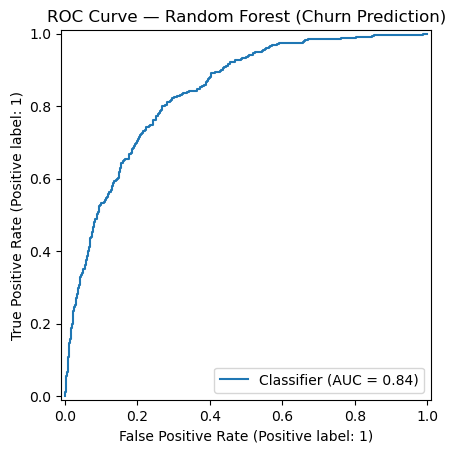

In [12]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay


df = pd.read_excel("churn_df_data_numeric.xlsx")


y = df["left_flag"].astype(int)
X = df.drop(columns=["left_flag"])

print("Target distribution:\n", y.value_counts())

if y.nunique() < 2:
    raise ValueError("Target y has only one class. Check left_flag values.")


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=25,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)


rf.fit(X_train, y_train)


y_prob = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print(f"Test ROC-AUC: {auc:.4f}")


RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Random Forest (Churn Prediction)")
plt.show()


## Random Forest - Top 10 Feature Importance (Business-driven features)
Note: Works with churn_df_data_numeric.xlsx (already numeric + one-hot encoded)

Target distribution:
 left_flag
0    4140
1    1496
Name: count, dtype: int64

Top 10 Random Forest Features:
contract_term_Month-to-month    0.216162
tenure_mo                       0.112842
contract_term_Two year          0.089086
total_billed                    0.066830
internet_tech_Fiber Optic       0.062831
monthly_fee                     0.059851
pay_method_Electronic check     0.059635
long_dist_fees_total            0.052282
avg_gb_download                 0.038513
num_add_ons                     0.035239
dtype: float64


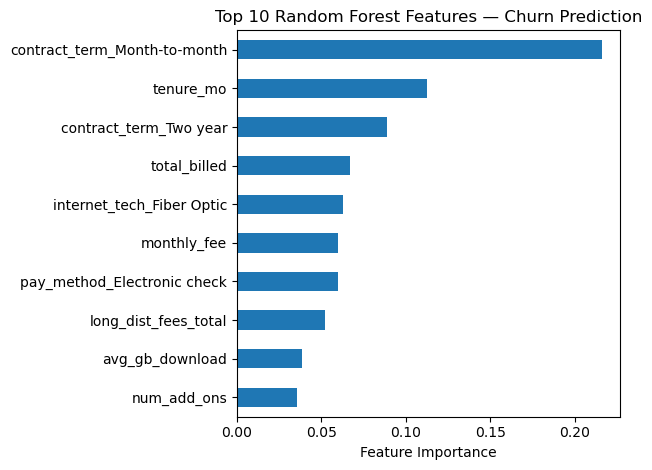

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


df = pd.read_excel("churn_df_data_numeric.xlsx")


y = df["left_flag"].astype(int)
X = df.drop(columns=["left_flag"])

print("Target distribution:\n", y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=25,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)


importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top10 = importances.head(10)

print("\nTop 10 Random Forest Features:")
print(top10)


plt.figure()
top10.sort_values().plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Top 10 Random Forest Features — Churn Prediction")
plt.tight_layout()
plt.show()


## RF vs “XGBoost Concept” Comparison (Boosting Proxy)

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

df = pd.read_excel("churn_df_data_numeric.xlsx")

# Target + Features
y = df["left_flag"].astype(int)
X = df.drop(columns=["left_flag"])

print("Target distribution:\n", y.value_counts())

if y.nunique() < 2:
    raise ValueError("Target y has only one class. Check left_flag values.")


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=6,
    min_samples_leaf=25,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

hgb = HistGradientBoostingClassifier(
    max_depth=4,
    learning_rate=0.05,
    max_iter=400,
    random_state=42
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_summary(model, Xtr, ytr):
    out = cross_validate(
        model,
        Xtr, ytr,
        cv=cv,
        scoring="roc_auc",
        return_train_score=True,
        n_jobs=-1
    )
    return {
        "train_auc_mean": float(np.mean(out["train_score"])),
        "val_auc_mean": float(np.mean(out["test_score"])),
        "val_auc_std": float(np.std(out["test_score"]))
    }

rf_cv = cv_summary(rf, X_train, y_train)
hgb_cv = cv_summary(hgb, X_train, y_train)

print("\n===== Cross-Validation (ROC-AUC, 5-Fold) =====")
print(
    f"Random Forest | Train AUC: {rf_cv['train_auc_mean']:.3f} "
    f"| Val AUC: {rf_cv['val_auc_mean']:.3f} "
    f"| Val Std: {rf_cv['val_auc_std']:.3f}"
)
print(
    f"Boosting (HGB) | Train AUC: {hgb_cv['train_auc_mean']:.3f} "
    f"| Val AUC: {hgb_cv['val_auc_mean']:.3f} "
    f"| Val Std: {hgb_cv['val_auc_std']:.3f}"
)


rf.fit(X_train, y_train)
hgb.fit(X_train, y_train)

rf_test_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])



Target distribution:
 left_flag
0    4140
1    1496
Name: count, dtype: int64

===== Cross-Validation (ROC-AUC, 5-Fold) =====
Random Forest | Train AUC: 0.872 | Val AUC: 0.844 | Val Std: 0.009
Boosting (HGB) | Train AUC: 0.974 | Val AUC: 0.837 | Val Std: 0.012
